In [170]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

import tensorflow_addons as tfa
import numpy as np
import random


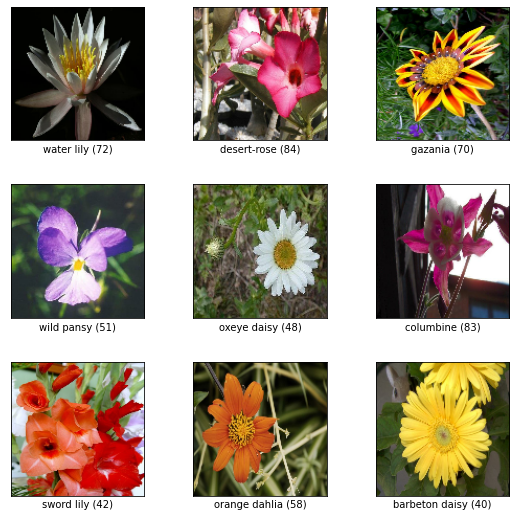

In [171]:
#Load the training and testing dataset
#TODO Validation dataset
(ds_train, ds_test, ds_val), ds_info = tfds.load('oxford_flowers102',
                                            split=['train', 'test', 'validation'],
                                            with_info=True, 
                                            shuffle_files=True,
                                            as_supervised=True)


#This gets the images ready 
shape = (128, 128, 3)
n_labels = 102
def normalize_img(img, label):
    img = tf.image.resize(img,shape[:2])
    img = tf.cast(img, tf.float32) / 255

    #img = tf.image.random_crop(value = img, size=(64, 64,3))
    
    #img = tf.expand_dims(img, axis=0)
    #img = tfa.image.random_cutout(img, (64,64), constant_values=1)

    return (img, label)


def randomize_img1(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img,0.15)
    img = tf.image.random_contrast(img,0.5,0.9)
    img = tf.image.random_saturation(img, 0.5,0.9)
    img = tf.image.random_hue(img, 0.2)
    return (img, label)

def randomize_img2(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_saturation(img, 0.4,0.9)
    return (img, label)

def randomize_img3(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img,0.15)
    img = tf.image.random_contrast(img,0.3,0.9)
    return (img, label)

def randomize_img4(img, label):
    img = tf.image.random_saturation(img, 0.5,0.9)
    img = tf.image.random_hue(img, 0.2)
    return (img, label)

def randomize_img5(img, label):
    img = tf.image.random_brightness(img,0.15)
    img = tf.image.random_contrast(img,0.3,0.9)
    return (img, label)

def randomize_img6(img, label):
    img = tf.image.random_flip_left_right(img)
    return (img, label)

def rotate_img(img, label):
    img = tfa.image.rotate(img, angles=0.5)
    return (img, label)

def random_move_img(img, label):
    img = tfa.image.translate(img, [np.random.random()*30-15,np.random.random()*30-15])
    return (img, label)


AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_aug_train = ds_train.map(randomize_img1)


ds_aug_train2 = ds_train.map(randomize_img2)
ds_temp_train = ds_aug_train.concatenate(ds_aug_train2)

ds_aug_train = ds_train.map(randomize_img5)
ds_temp_train = ds_temp_train.concatenate(ds_aug_train)

ds_aug_train = ds_train.map(rotate_img)
ds_aug_train = ds_aug_train.map(random_move_img)
ds_temp_train = ds_temp_train.concatenate(ds_aug_train)

ds_aug_train = ds_train.map(rotate_img)
ds_aug_train = ds_aug_train.map(random_move_img)
ds_aug_train = ds_aug_train.map(randomize_img5)
ds_aug_train = ds_aug_train.map(randomize_img3)
ds_temp_train = ds_temp_train.concatenate(ds_aug_train)

ds_train = ds_train.concatenate(ds_temp_train)

tfds.visualization.show_examples(ds_train, ds_info)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(1000)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(AUTOTUNE) 

ds_val = ds_val.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_val = ds_val.cache()
ds_val = ds_val.shuffle(1000)
ds_val = ds_val.batch(BATCH_SIZE)
ds_val = ds_val.prefetch(AUTOTUNE) 



In [172]:
print(ds_train.cardinality().numpy() * BATCH_SIZE)

6144


In [177]:
#Making the NN model
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=shape),
#     tf.keras.layers.BatchNormalization(),
    
#     tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D((2, 2), strides=2),
#     tf.keras.layers.Dropout(0.25),

#     tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.25),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(256, activation="relu"),
#     tf.keras.layers.Dense(n_labels, activation="softmax")]
# )

#Making the NN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=shape),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(n_labels, activation="softmax")]
)

#Learning rate scheduler (EXPLAIN THIS)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)


model.compile(
    optimizer=keras.optimizers.Adam(lr_schedule),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [178]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 dropout_35 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_56 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 32, 32, 64)      

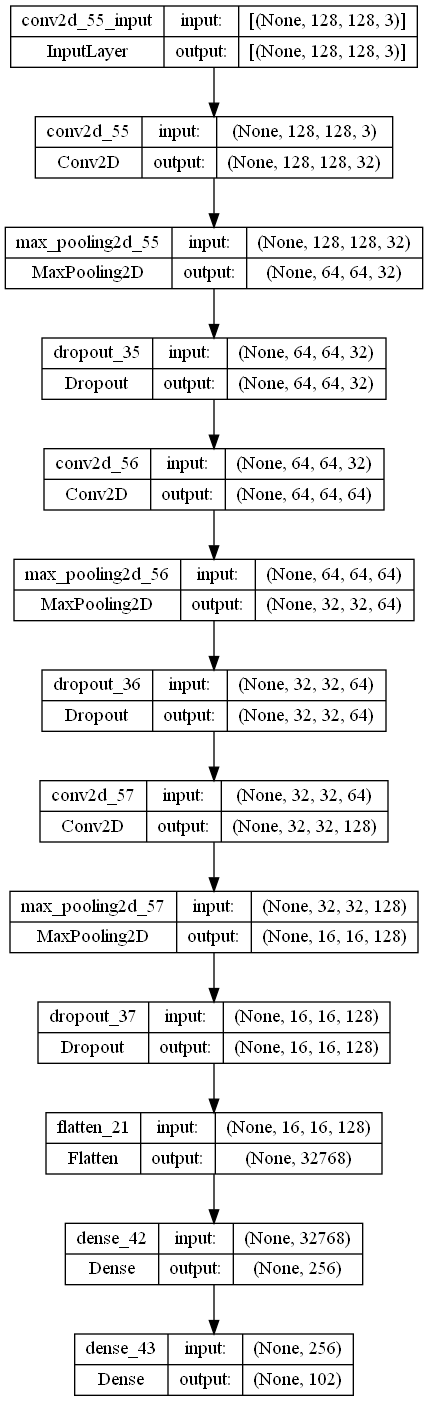

In [179]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [180]:


#Train the model 
history = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_val)

Epoch 1/10
96/96 [==============================] - 108s 1s/step - loss: 4.5088 - accuracy: 0.0212 - val_loss: 4.1487 - val_accuracy: 0.0490
Epoch 2/10
96/96 [==============================] - 107s 1s/step - loss: 3.6853 - accuracy: 0.1095 - val_loss: 3.5947 - val_accuracy: 0.1441
Epoch 3/10
96/96 [==============================] - 107s 1s/step - loss: 3.0528 - accuracy: 0.2443 - val_loss: 3.4378 - val_accuracy: 0.1863
Epoch 4/10
96/96 [==============================] - 107s 1s/step - loss: 2.5121 - accuracy: 0.3753 - val_loss: 3.3783 - val_accuracy: 0.2363
Epoch 5/10
96/96 [==============================] - 107s 1s/step - loss: 1.9084 - accuracy: 0.5131 - val_loss: 3.9368 - val_accuracy: 0.2157
Epoch 6/10
33/96 [=========>....................] - ETA: 1:08 - loss: 1.2507 - accuracy: 0.6842

KeyboardInterrupt: 

ValueError: in user code:

    File "C:\Users\tf877\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\tf877\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\tf877\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\tf877\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1788, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\tf877\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\tf877\AppData\Roaming\Python\Python39\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_18" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(None, None, 3)


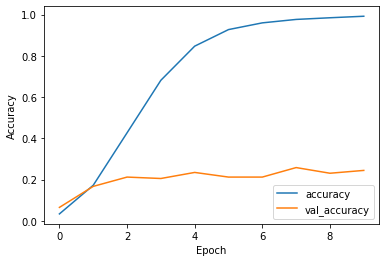

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_test, verbose=2)